# **SetFit: few-shot learning for text classification**

# Introduction

SetFit is a prompt-free framework for few-shot fine-tuning of SentenceTransformers, a Python framework for sentence, text and image embeddings. A SetFit model has two components: a body and a head. The body is a pretrained embeddings model, which we will finetune with our few-shot dataset; the head is a classification model, which we will train from scratch. In the end, we will have a text classification model that has been fine-tuned to our specific set of labels.

Take a look at the image below (credit: https://github.com/huggingface/setfit). To train a SetFit model, we will -under the hood- be carrying out the following steps:

1. Generate sentence pairs from our few-shot training data for contrastive learning
2. Fine-tune a pretrained embeddings model
3. Encode our texts with the resulting embeddings
4. Train a classification head

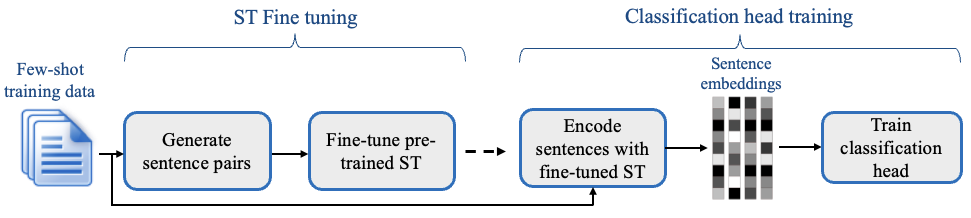

Take a second to appreciate this: by the time we are done, we will have a model capable of labelling owr own data after having fine-tuned it with just a few examples per class. And few here means less than 10.

# Preliminaries

First, we need install the libraries we will be using for the tutorial. These are -naturally- `setfit` for the model and `datasets` to wrangle our data into the [arrow](https://huggingface.co/docs/datasets/about_arrow) `dataset` data type used by the framework. The latter is actually using [Arrow](https://huggingface.co/docs/datasets/about_arrow).

In [57]:
%pip install setfit datasets -q

# Data wrangling

We will be working with a synthetic dataset we will create by wrangling a dataset from `labelled_data.csv` from [this tutorial](https://huggingface.co/datasets/dspoka/ccai-nlp-tutorial-1). The data consists of scientific journal article abstracts that are labelled with 5 possible options. To keep our task simple, we will only be using those abstracts that have one single label.

In [58]:
import pandas as pd

url = 'https://huggingface.co/datasets/dspoka/ccai-nlp-tutorial-1/raw/main/labelled_data.csv'
data = pd.read_csv(url)

Let's inspect the shape, variables and some examples in our data:

In [59]:
print(list(data))
print(data.shape)

['id', 'abstract', 'title', 'seen', 'INCLUDE', '12 - Coastal and marine Ecosystems', '12 - Human and managed', '12 - Mountains, snow and ice', '12 - Rivers, lakes, and soil moisture', '12 - Terrestrial ES']
(2500, 10)


We have 2,500 labelled abstracts. We won't be using `title`, `seen` or `include` in this exercise. Also, the labels are too long, so we will be renaming them.

In [60]:
keep = [0, 1, 5, 6, 7, 8, 9]
data = data.iloc[:, keep].copy()
data = data.loc[data.iloc[:, 2:].sum(axis=1)==1, :]
names = {data.columns[2]: 'coastal',
         data.columns[3]: 'human',
         data.columns[4]: 'mountains',
         data.columns[5]: 'rivers',
         data.columns[6]: 'terrestrial'}
data.rename(columns=names, inplace=True)
data.iloc[0:5,2:7].style

,coastal,human,mountains,rivers,terrestrial
0,0.000000,1.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,1.000000
2,0.000000,0.000000,0.000000,0.000000,1.000000
3,0.000000,1.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000,0.000000


As you can see, our data is one-hot encoded. For our particular approach, we'll need a `label` column containing the one label each abstract corresponds to, we'll fix this. After you run the code, click on the icon that looks like a table (if you hover on it, 'Convert this dataframe to an interactive table') to see three examples of abstracts and their corresponding labels.

In [61]:
# Label
labels = ['coastal', 'human', 'mountains', 'rivers', 'terrestrial']
data['label'] = data.loc[:, labels].idxmax(axis=1)
data = data.drop(columns=labels)
data.loc[0:2]

,id,abstract,label
0,1448689,"The city of Bismarck, North Dakota has one of ...",human
1,3281128,Changing precipitation regimes can profoundly ...,terrestrial
2,900708,Climate influences forest structure through ef...,terrestrial


# Split and shoot

We now split our dataset into train and test sets. In the FSL context, the train set will consist of $n$ examples -or shots- per class. In this crucial step, we will be choosing the number of shots we will be using for fine-tuning. We will use the remaining rows as a test set.

In the following code chunk, we have selected 5, as we have obtained acceptable results with it in terms of performance and compute time. This isn't the best performing number; refer to the last section for some exploration of the fine-tuning of this hyperparameter.

Note: since this is just a tutorial for demonstratipn purposes, we will not be worrying about the implications of changing the split as we try different numbers of shots.

In [ ]:
# Constants
shots = 5
seed = 42

train = pd.DataFrame()
for label in labels:
    filtered = data.loc[data["label"] == label]
    shuffled = filtered.sample(frac=1, random_state=seed)
    selected = shuffled.head(shots)
    train = pd.concat([train, selected])

test = data[~data['id'].isin(train['id'])]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We now convert our sets into `arrow`readable datasets:

In [ ]:
from datasets import Dataset
train_ds = Dataset.from_pandas(train)
test_ds = Dataset.from_pandas(test)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Fine-tuning and training

Now that we have all the ingredients on the data side, its time to implement the SetFit pipeline. We will use `sentence-transformers/all-mpnet-base-v2` as body and the default logistic regression head. After trying different settings, we will be running with a parameter combination that serves our tutorial's purposes, but you can of course use any to test this and even do some hyperparameter tuning if needed.

Considerations:
- Use a GPU runtime or this will take too long
- You will se a message reading "model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights". This is expected, as we will be training this model this model
- Larger batch sizes will produce 'CUDA out of memory' errors, so start small; this is also the case for the number of iterations



In [ ]:
from setfit import SetFitModel, SetFitTrainer

# Load a SetFit model from Hub and instantiate
model_id = "sentence-transformers/all-mpnet-base-v2"
model = SetFitModel.from_pretrained(model_id)

# Create trainer
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    metric="accuracy",
    batch_size=1,
    num_iterations=5, # The number of text pairs to generate for contrastive learning
    num_epochs=3,
    column_mapping={"abstract": "text", "label": "label"}
)

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
<ipython-input-47-34ad28d31c70>:8: DeprecationWarning: `SetFitTrainer` has been deprecated and will be removed in v2.0.0 of SetFit. Please use `Trainer` instead.
  trainer = SetFitTrainer(
Applying column mapping to the training dataset
Applying column mapping to the evaluation dataset


Map:   0%|          | 0/25 [00:00<?, ? examples/s]

Time to train the SetFit model! Remebter this consists of the fine-tuning of the embeddings body and training of the classification head.

In [ ]:
%time trainer.train()

***** Running training *****
  Num examples = 250
  Num epochs = 3
  Total optimization steps = 750
  Total train batch size = 1


Step,Training Loss


CPU times: user 2min 4s, sys: 1.38 s, total: 2min 6s
Wall time: 2min 21s


In [62]:
%time metrics = trainer.evaluate()

print(f"Model: {model_id}")
print(f"Shots: {shots}")
print(f"Accuracy: {metrics['accuracy']}")

***** Running evaluation *****


CPU times: user 25.3 s, sys: 160 ms, total: 25.5 s
Wall time: 28 s
Model: sentence-transformers/all-mpnet-base-v2
Shots: 5
Accuracy: 0.829683698296837


Ant there it is. We have achieved an accuracy of 83% with only 5 shots per class, 5 contrastive pairs and three epochs. This may seem low, considering what we are used to see in other contexts. But remember, we started with an embeddings model that had never seen our data or been trained for our particular task. Also, look at how long it took for the whole training process to complete: not even 2.5 minutes on freely available compute!

This is a great starting point to fine-tune hyperparameters from!

# Some hyper-parameter tuning

To offer you some sense of what the aforementioned hyperparameter tuning yields, we ran the same model for different numbers of shots per class: from 1 to 15. You will have to take our word for these results, but it should be very simple to do some testing yourself.

The results are shown in the graph below.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


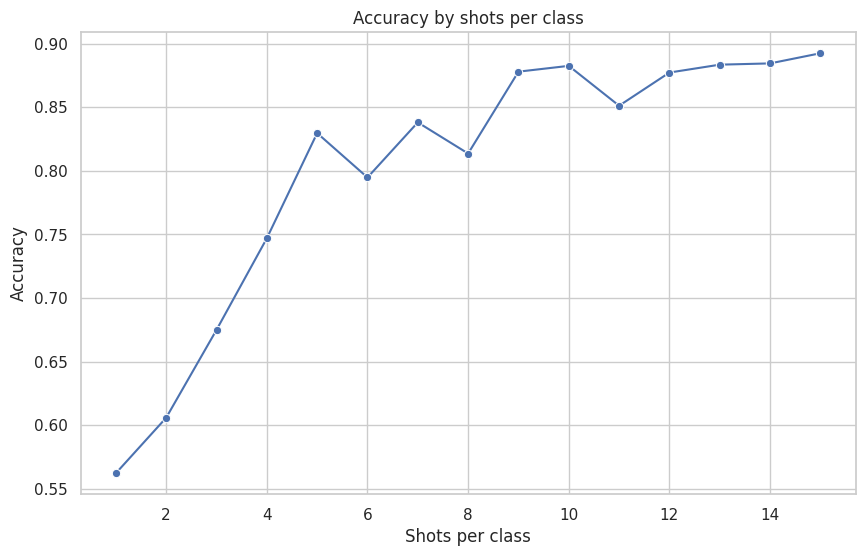

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Provided data
shot_number = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
accuracy = [0.562252181, 0.60589172, 0.674959872, 0.746978243, 0.829683698,
            0.794788274, 0.838103025, 0.8136289, 0.877988458, 0.88254756,
            0.85120532, 0.877295492, 0.883487008, 0.884485666, 0.892464014]

# Create a Seaborn line plot
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))
sns.lineplot(x=shot_number, y=accuracy, marker='o', color='b')

# Set plot labels and title
plt.xlabel('Shots per class')
plt.ylabel('Accuracy')
plt.title('Accuracy by shots per class')

# Display the plot
plt.show()

As you can see, the model performs just shy of 90% accuracy. The best performance is achieved with 15 shots. Remember this implies 75 examples, which -depending on your context- may already be too many.

To improve this performance, you can also play around with the other parameters. But the best part, is that the body and head are also factors you can tinker with to achieve an acceptable performance for your particular tasks.